# 02. Neural Network Classification with PyTorch

Online book of course: <https://www.learnpytorch.io/02_pytorch_classification/>

All other Resources: <https://github.com/mrdbourke/pytorch-deep-learning>

Classification = a proflem of predicting whether something is one thing or another (there can be multiple things as the options)

Classification problems is one of the main problems of machine learning

Examples of Classifications
* Binary Classification = One thing or another (1 or 0)
* Multiclass Classification = more than one thing or another
* Multilabel Classification = Multiple label options per sample
* and so on... 

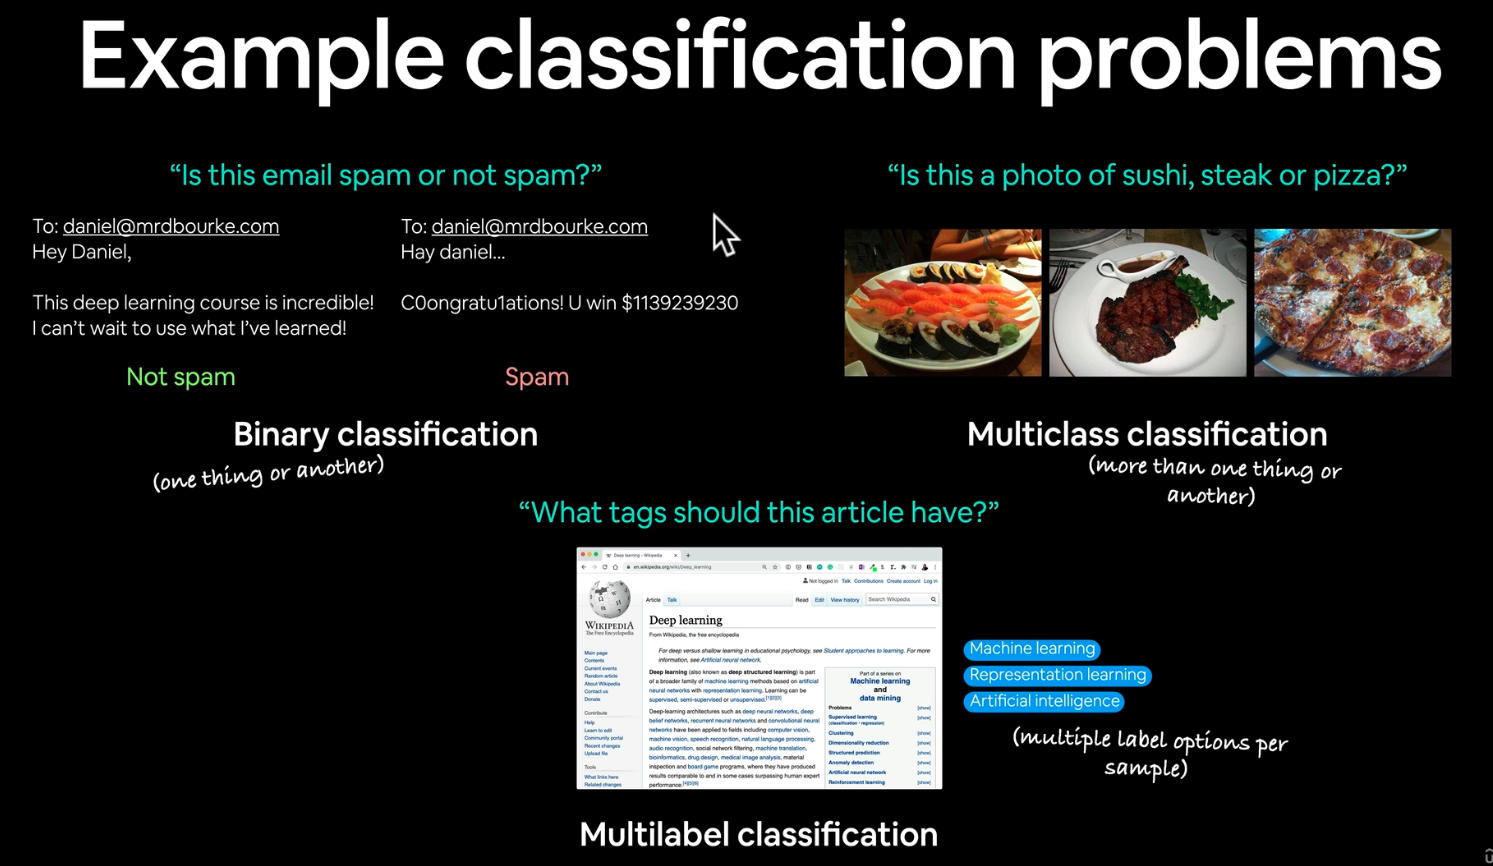

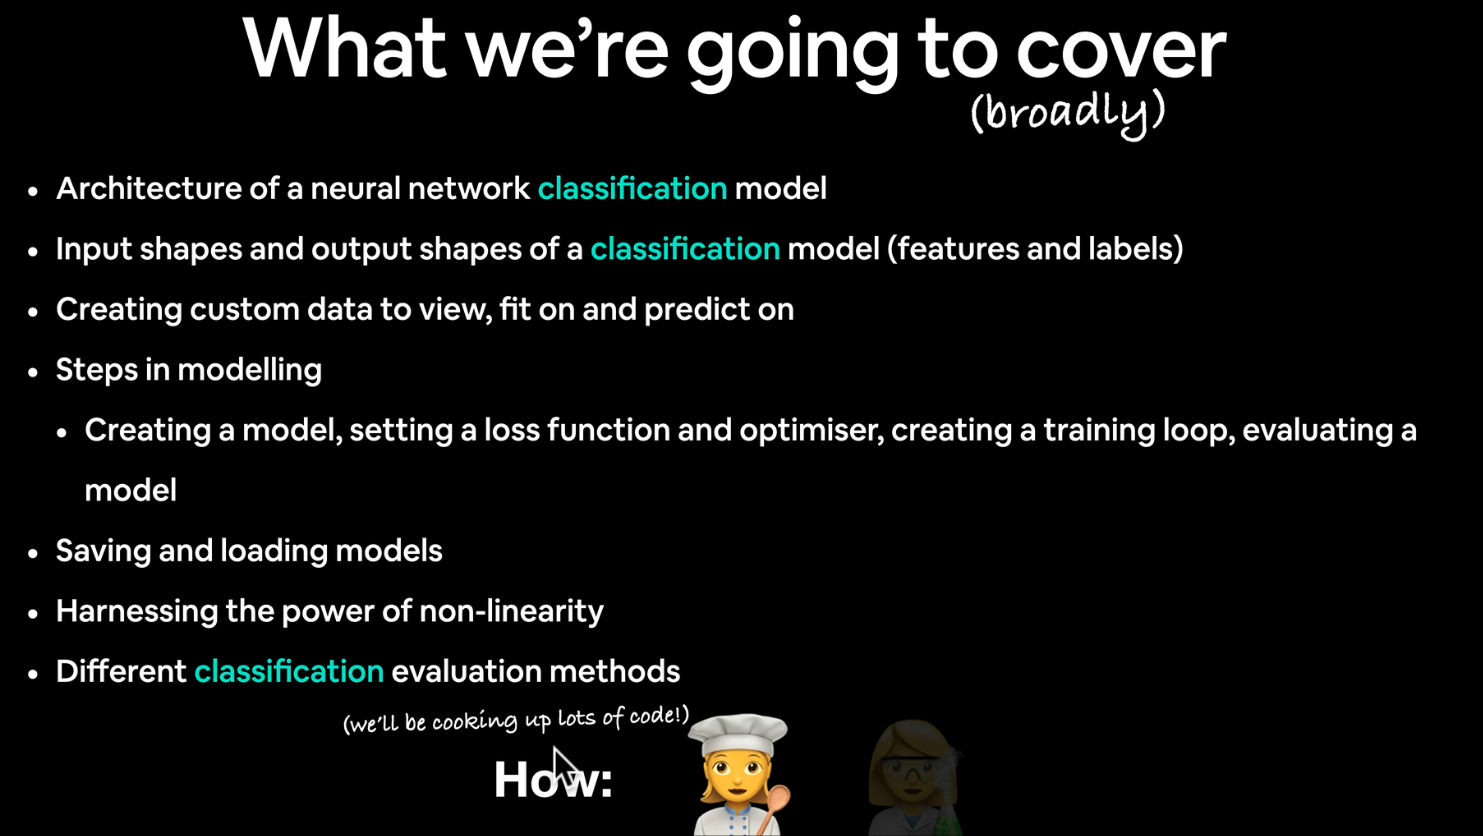


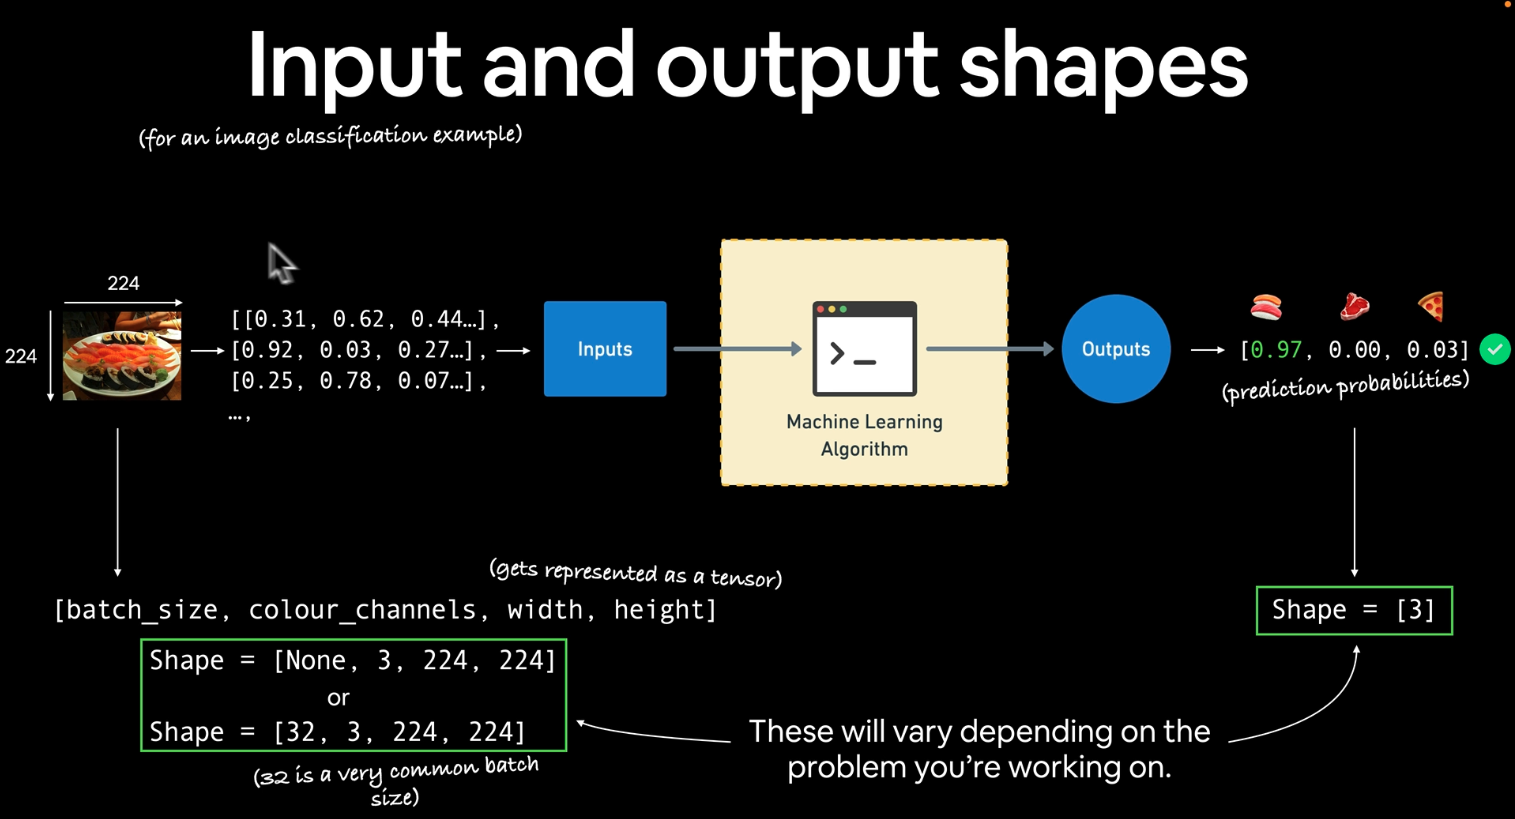

Shapes vary on the problem

Inputs are encoded numerical representation of data

Outputs are the prediction probability per class 

## 0) Overview: Typical Architecture of a Classification Neural Network

Hyperparameter = parameters that we decide the value of

Binary Classification = total number of outputs is 2, one or the other

Multiclass Classification = total number of outputs is 3 or more, more than one thing or another

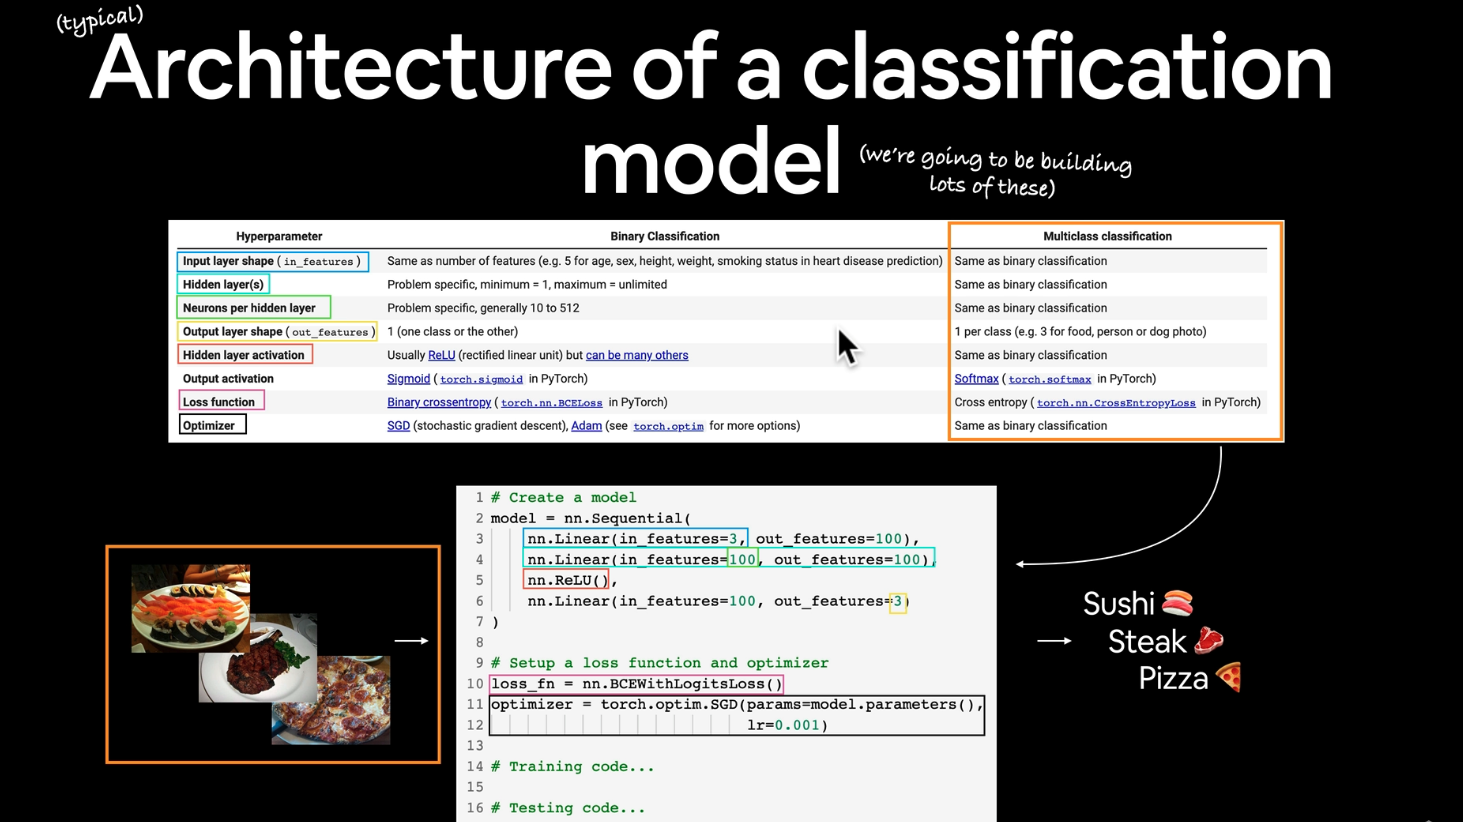

Next: The Flow
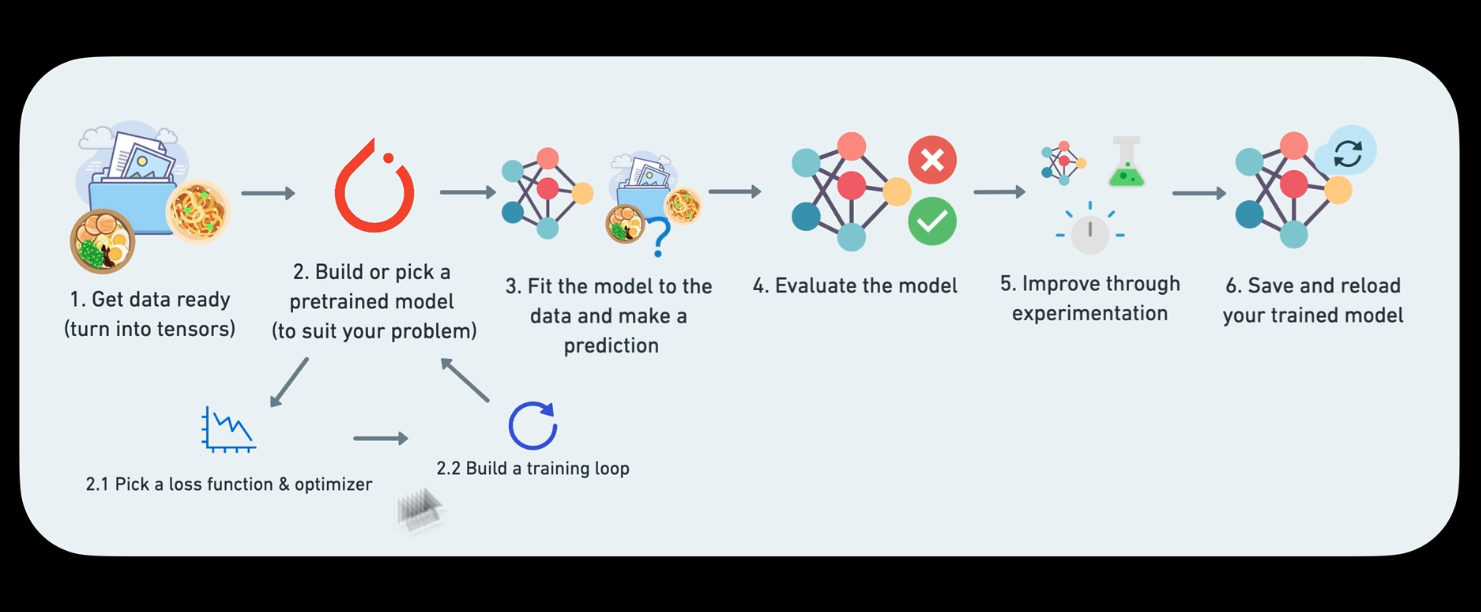

## 1) Make classification data and get it ready

`sklearn` a library for machine learning

<https://scikit-learn.org/stable/datasets/toy_dataset.html>

In Terminal:
        
        conda install scikit-learn

X is for tensors and labels

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples =1000

# create circles
X, y = make_circles(n_samples, 
                    noise=0.03, # increase randomness
                    random_state=42) # for reproducibility

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X:\n{X[:5]}")
print(f"First 5 labels of y:\n{y[:5]}")

First 5 samples of X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 labels of y:
[1 1 1 1 0]


In [5]:
# Make DataFrame of Circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], 
                        "X2": X[:, 1], 
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [6]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

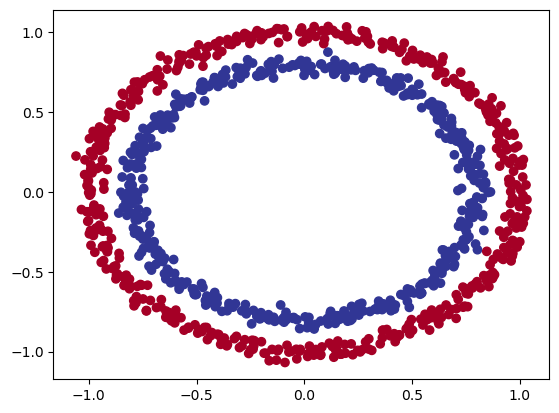

In [7]:
# Visualize, Visualize, Visualize!
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu)

**Note**: the data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [10]:
import torch
torch.__version__

'2.3.1'

In [11]:
# turn data into tensors
X = torch.from_numpy(X).type(torch.float) #float is the same as float32
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [12]:
type(X), torch.float32, torch.float32

(torch.Tensor, torch.float32, torch.float32)

In [13]:
# split data into train and test sets
from sklearn.model_selection import train_test_split

# NOTE: order of X and y is very important
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% of data to test set, 80% to train set
                                                    random_state=42)

In [14]:
print(f"Total samples in our data: {len(X)}")
print(f"Samples in train set: {len(X_train)}")
print(f"Samples in test set: {len(X_test)}")
print("\n")
print(f"Total labels in our data: {len(y)}")
print(f"Labels in train set: {len(y_train)}")
print(f"Labels in test set: {len(y_test)}")

Total samples in our data: 1000
Samples in train set: 800
Samples in test set: 200


Total labels in our data: 1000
Labels in train set: 800
Labels in test set: 200


## 2. Build a model

Let's build a model to classifiy our blue and red dots.

To do so, we want to:
1. Setup device agonistic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [15]:
# import PyTorch and nn
import torch
from torch import nn

# For macbook m1 pro
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [16]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

Device Agnostic code set, now create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()`layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target `device`

In [17]:
X_train.shape

torch.Size([800, 2])

In [18]:
from sklearn import datasets
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        # Usually multiples of 8 for optimal performance
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feauture (same shape as y)

    # 3. Define the forward method that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output
    
# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

# NOTE: We place it in a class so we can easily reuse it later by calling CircleModelV0()

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
device

'mps'

In [20]:
next(model_0.parameters()).device

device(type='mps', index=0)

<https://playground.tensorflow.org/>

In [21]:
# nn.Sequential(), another way to define the model we created above
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [22]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 1.8407e-01,  7.8142e-02],
                      [-3.4810e-01,  1.4254e-04],
                      [ 3.1445e-01, -3.6656e-02],
                      [ 6.8939e-01, -2.5738e-01],
                      [ 3.7074e-01, -3.4604e-01]], device='mps:0')),
             ('0.bias',
              tensor([-0.3009, -0.3100,  0.3392, -0.4681,  0.6309], device='mps:0')),
             ('1.weight',
              tensor([[-0.0677, -0.2343,  0.3519,  0.2859, -0.2917]], device='mps:0')),
             ('1.bias', tensor([0.4095], device='mps:0'))])

Sequential() is an easier way to develop a striaght forward Neural Network

But as the model grows in complexity, we need to subclass (nn.Module)


In [23]:
# Make predictions with the model
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions: \n {torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 Labels: \n {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: 
 tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.]], device='mps:0')

First 10 Labels: 
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [24]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

When we create our models and when we evaluate it, we want our predictions to be in the same format as our labels

### 2.1 Stepup Loss function and optimizer

Which loss function or optimizer should you use?

again... this is problem specific:
* For example, for regression you might want MAE or MSE
* For Classification, you might wanto binary cross entropy or categorical cross entrophy (cross entropy)

AS a reminder, a loss function measures how wrong our model's predictions are.

And for optimizers, two and the most common and useful are SGD and Adam, however PyTorch as many built in options.

* For some common choices of loss functions and optimizers - <https://www.learnpytorch.io/02_pytorch_classification/#21-setup-loss-function-and-optimizer>
* For the loss function, we're going to use `torch.nn.BECWithLogitsLoss()`, for more on what binary cross entropy (BCE) is, check out this article - <https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a>
* for a definition on what a logit is in deep learning - <https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow>
* fpr different optimizers see `torch.optim`

In [25]:
# Setup the loss function
# loss_fn = nn.BCELoss() # BCELoss = binary cross-entropy loss, requires input to have gone through the sigmoid activation function pior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(model_0.parameters()
                            , lr=0.1) # SGD = stochastic gradient descent

In [26]:
# Calculate accuracy - out of 100 examples, what percentage does out model get right?
def accuracy_fn(y_true, y_pred):
    return torch.sum(y_true == torch.round(y_pred)).item() / len(y_true)

def accuracy_fn_1(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc


## 3. Train Model

To train our model, we're going to need to build a training loop with the following steps:
1. Forward Pass
2. Calculate the loss
3. Optimizer zero grad
4. loss backward (Backpropagation)
5. Optimizer (gradient descent)

### 3.1 Going from raw logits -> Prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**
* logits = raw outputs of our model without being passed to any activation function

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary crossentrophy and softmax for multiclass classification)

Then we can convert our models prediction probabilities to **prediction labels** by either rounding them or taking the `argmac()`.

In [27]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.2095],
        [0.3169],
        [0.1123],
        [0.2362],
        [0.4053]], device='mps:0')

In [28]:
# We need to pass the logits through a sigmoid function to get the predicted probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5522],
        [0.5786],
        [0.5281],
        [0.5588],
        [0.6000]], device='mps:0')

For Our prediction probability values, we need to perform a range-style round on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` <0.5, `y=0` (class 0)


In [29]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In Full (Logits -> pred probs -> pred labels)
y_preds_full = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5])) # better to be in inference mode 

# check for equality
print(torch.eq(y_preds.squeeze(), y_preds_full.squeeze()))

# get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='mps:0')


tensor([1., 1., 1., 1., 1.], device='mps:0')

In [30]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a Training and test loop

In [31]:
torch.manual_seed(42)
torch.mps.manual_seed(42) # We don't need this but it's good to have for reproducibility

# Set the number of epochs
epochs = 100

# Put the data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loops
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logits -> Pred Probs -> Pred Labels

    # 2. Calculate Loss/Accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), y_train) # nn.BCELoss expects pred probs as inputs
    loss = loss_fn(y_logits, ## nn.BCEWithLogitsLoss expects 
                     y_train)
    acc = accuracy_fn_1(y_true = y_train , # nn.BCEWithLogitsLoss expects raw logits as input
                       y_pred = y_pred)
    
    # 3. Optimizer Zero the gradients
    optimizer.zero_grad()

    # 4. Backward pass
    loss.backward()

    # 5. Step (update weights) optimizer (gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test Loss/Accuracy
        test_loss = loss_fn(test_logits, 
                            y_test)
        
        test_acc = accuracy_fn_1(y_true = y_test,
                                y_pred = test_pred)
    
    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.2f} | Train Acc: {acc:.2f}% | Test Loss: {test_loss:.2f} | Test Acc: {test_acc:.2f}%")


Epoch: 0 | Train Loss: 0.71 | Train Acc: 50.00% | Test Loss: 0.71 | Test Acc: 50.00%
Epoch: 10 | Train Loss: 0.70 | Train Acc: 54.75% | Test Loss: 0.70 | Test Acc: 51.00%
Epoch: 20 | Train Loss: 0.70 | Train Acc: 52.25% | Test Loss: 0.70 | Test Acc: 48.00%
Epoch: 30 | Train Loss: 0.69 | Train Acc: 52.00% | Test Loss: 0.70 | Test Acc: 48.00%
Epoch: 40 | Train Loss: 0.69 | Train Acc: 51.75% | Test Loss: 0.70 | Test Acc: 48.00%
Epoch: 50 | Train Loss: 0.69 | Train Acc: 51.00% | Test Loss: 0.70 | Test Acc: 48.00%
Epoch: 60 | Train Loss: 0.69 | Train Acc: 50.25% | Test Loss: 0.70 | Test Acc: 49.00%
Epoch: 70 | Train Loss: 0.69 | Train Acc: 51.00% | Test Loss: 0.70 | Test Acc: 48.50%
Epoch: 80 | Train Loss: 0.69 | Train Acc: 50.50% | Test Loss: 0.70 | Test Acc: 47.50%
Epoch: 90 | Train Loss: 0.69 | Train Acc: 50.50% | Test Loss: 0.70 | Test Acc: 47.50%


In [32]:
loss_fn # More numerically stable than BCELoss()

BCEWithLogitsLoss()

## 4. Make predictions and evaluate the model

From the metrics it looks like out model isn't learning anything..

So to inspect it  let's make some predictions and make them visual.

In other words : "Visualize, visualize, visualize!

To do so, we're going to import a function called `plot_decision_boundary()` 
* <https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py>

A great resource: <https://madewithml.com/>

In [33]:
import requests
from pathlib import Path

# Download helper functions from PyTorch repo (if it's not already downloaded)
if Path("help_functions.py").is_file():
    print("helper_functions.py already exists, skipping download.")
else:
    print("Downloading help_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


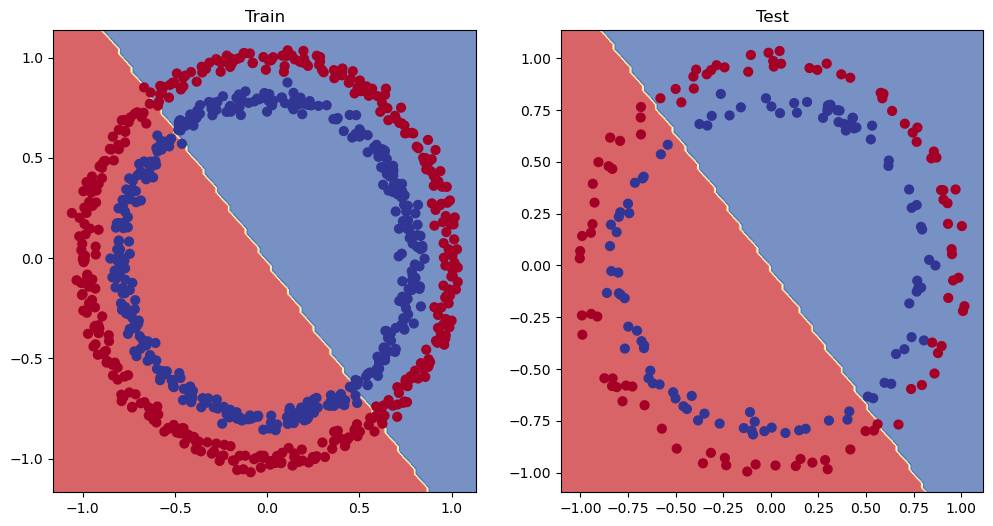

In [34]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model_0, 
                       X=X_train, 
                       y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, 
                       X_test, 
                       y_test)

## 5. Improving a model (from a model perspective)
* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer (more epochs)
* Changing the activation function (we're using sigma right now)
    * however, we can put more activation models within our model
* Change the learning rate
* Change the loss function
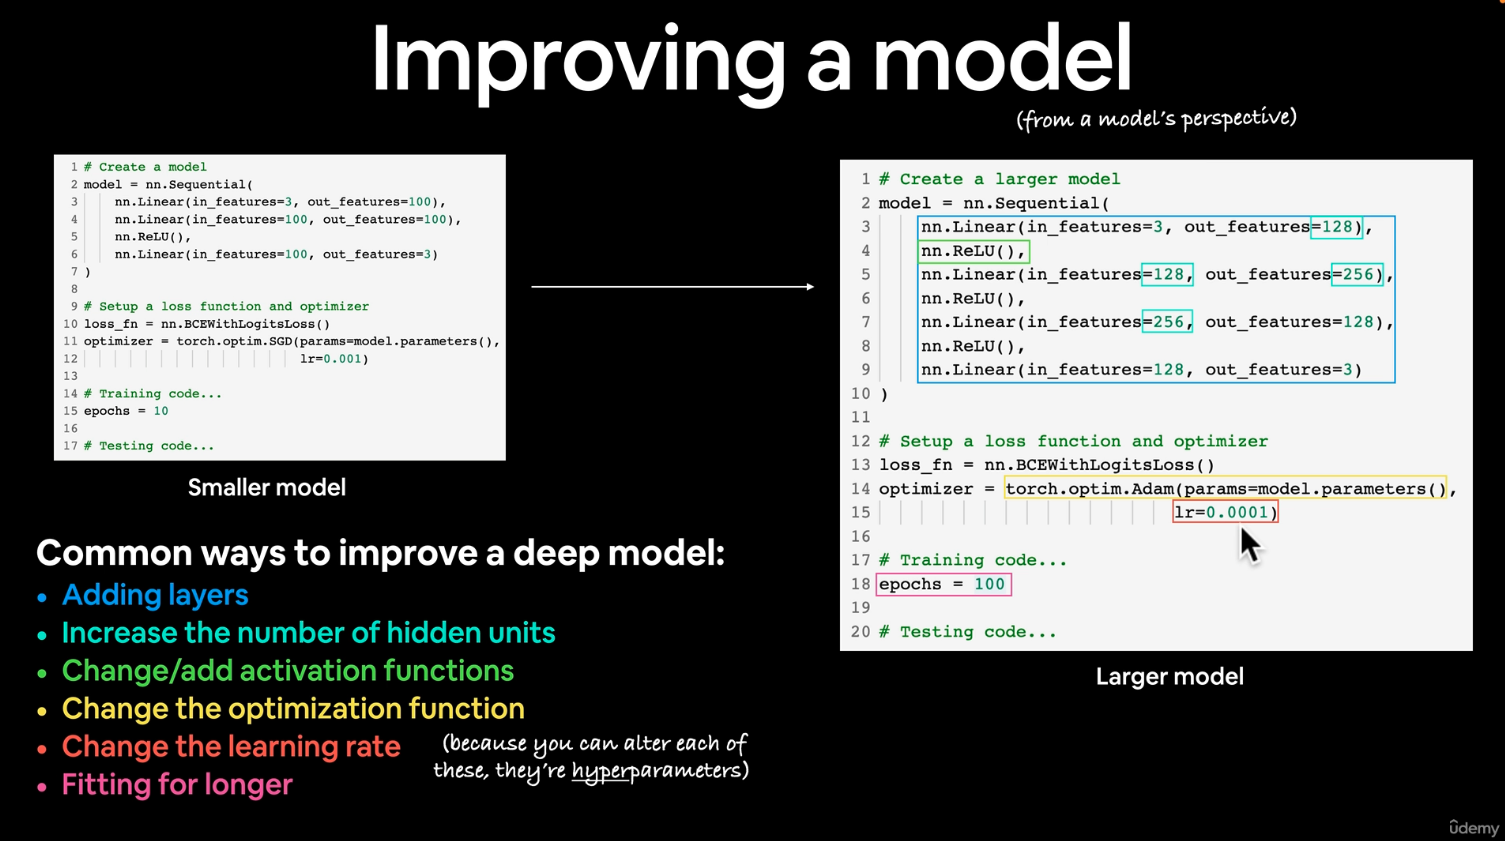